In [ ]:
! pip install networkx
! pip install matplotlib
! pip install pyvis

How to to use:

upload steps_format file. This file contains information on the amount of steps to visualize, the amount of devices, and the amount of wires. In this current version devices and wires are only refered to as their ID which starts from 0 and increments up. The structure of how the wires are connected to the devices needs to be hardcoded at the moment.

```
STEP EVENT FORMAT
{
    "steps": 10,
    "devices": 2,
    "wires": 1,
    "step-0": {
        "d-1": "IDLE",
        "d-2": "IDLE",
        "w-1": "EMPTY"
    },
    more steps...
}
```

In [ ]:
# part 1: parse step input file
import json
step_file_dict = json.load(open("test.json"))

simulation_steps = step_file_dict["steps"]
amount_of_devices = step_file_dict["devices"]
amount_of_wires = step_file_dict["wires"]

for step_index in range(simulation_steps):
  print("\nstep: " + str(step_index))
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    print("device-" + str(device_index) + " state: " + device_state)

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]
    print("wire-" + str(wire_index) + " state: " + wire_state)

/usr/local/lib/python3.9/dist-packages/IPython/core/formatters.py:345: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  return method()


/usr/local/lib/python3.9/dist-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


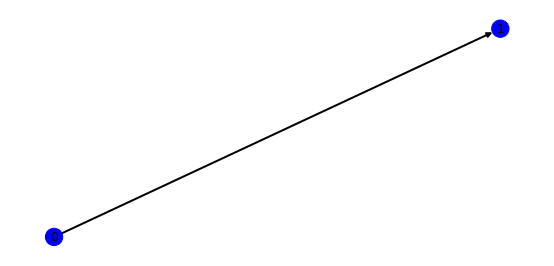

In [ ]:
# %matplotlib inline
from matplotlib import pyplot as plt, animation
from matplotlib import rc
from IPython.core.display import display, HTML
import networkx as nx
import random


# set up animation figure
rc('animation', html='jshtml')
fig = plt.figure()

# create and populate graph
G = nx.DiGraph()
G.add_node(0)
G.add_node(1)
G.add_edge(0,1, color='green', weight=4)
pos = nx.spring_layout(G) # keep position of nodes


def animate(frame):
  # animate a frame based on the state
  fig.clear()
  
  device_color_map = []
  wire_color_dict = G.edges()

  # get the step for this frame
  step_index = frame
  step = step_file_dict["step-" + str(step_index)]
  
  # loop through each device's state in this step
  for device_index in range(amount_of_devices):
    device_state = step["d-" + str(device_index)]
    if(device_state == "IDLE"):
      device_color_map.append("blue")
    else:
      device_color_map.append("green")

  # loop through each wire's state in this step
  for wire_index in range(amount_of_wires):
    wire_state = step["w-" + str(wire_index)]
    if(wire_state == "EMPTY"):
      G[0][1]['weight'] = 2
    else:
      G[0][1]['weight'] = 6

  # get weights for wires
  edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

  nx.draw(G, pos=pos, node_color=device_color_map, width=weights, with_labels=True)

ani = animation.FuncAnimation(fig, animate, frames=simulation_steps, interval=1000, repeat=True)
ani